This notebook is for running tests for the first referee report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import catwoman, batman

In [4]:
## some useful conversions
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

## handy calculations
## functions to measure the points of transit contact
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

def calc_H(T, M, R, mm=2.3):
    """ Calculates the approximate scale height of a planet's atmosphere, using the equation
     scale height = kT / mg
    
    Inputs: T = the atmospheric temperature in [K]; M = the planet's mass in [kg]; 
            R = the planet's radius in [m]; mm = mean mass of a molecule in the atmosphere [amu], this is
                   default set to 1 amu = 1 proton mass (for now)
    Outputs: H = the scale height in [m]
    """
    # constants:
    amu = 1.67e-27 # [kg]; atomic mass unit in [kg]
    k = 1.38e-23 # [Joule/K]; Boltzmann constant
    G = 6.674e-11 # [m^3/kg/s^2]; Gravitational constant
    Mjupiter = 1.9e27 # [kg]; mass of Jupiter
    Rjupiter = 69911000.0 # [m]; approx. radius of Jupiter
    # computing the numerator for the scale height equation:
    E_thermal = k*T # [Joule]
    # computing the denominator:
    g = G*M/(R**2) # gravitational acceleration in [m/s^2]
    meanmass = mm*amu
    denominator = meanmass*g # [kg*m/s^2]
    # compute the scale height:
    H = E_thermal / denominator # [meters]
    return H

Test 1 -- This is for their comment about the transit durations. Test whether the total transit durations for an asymmetric vs. uniform-limb planet are equal or not as a function of the degree of limb asymmetry.

In [31]:
# create a planet (using WASP-39b parameters)
tc = 0. # [day]
per = 4.0552941 # [day]
a = 11.55 # [stellar radii]
inc = 90.#87.32 # [degrees]
phi = 90.
ecc = 0.
w = 90.
r = 0.1457 # [stellar radii]
Rs = 0.92868 # [Rsun]
Mp_jup = 0.281 # [jupiter masses]
Teq = 1166.0 # [K]
T14 = 2.8032 # duration [hours]

# calculate things in physical units
a_meter = a * Rs * Rsun_to_meter
per_seconds = per*day_to_second
Rs_meter = Rs * Rsun_to_meter
Rp_meter = r * Rs_meter
Mp_kg = Mp_jup * Mjup_to_kg

# calculate other things
v_orb = (2.*np.pi*a_meter) / (per_seconds) # [m/s]
H = calc_H(Teq, Mp_kg, Rp_meter, mm=2.3) # [m]

# fine time axis:
t_int = 0.05 # [s] per integration
obs_window_size = (1.0*T14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

## -- Initialize Catwoman model:
aparams  = catwoman.TransitParams()
aparams.t0 = tc                          #time of inferior conjuction (in days)
aparams.per = per                         #orbital period (in days)
aparams.rp = r                        #top semi-circle radius (in units of stellar radii)
aparams.rp2 = r                        #bottom semi-circle radius (in units of stellar radii)
aparams.a = a                         #semi-major axis (in units of stellar radii)
aparams.inc = inc                        #orbital inclination (in degrees)
aparams.ecc = ecc                        #eccentricity
aparams.w = w                         #longitude of periastron (in degrees)
aparams.limb_dark = "uniform"          #limbs darkening model
aparams.phi = phi                         #angle of rotation of top semi-circle (in degrees)
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model
#asymLC = asymmodel.light_curve(params)                #calculates light curve

## -- Initialize Batman model:
uparams  = batman.TransitParams()
uparams.t0 = tc                          #time of inferior conjuction (in days)
uparams.per = per                         #orbital period (in days)
uparams.rp = r                        #top semi-circle radius (in units of stellar radii)
uparams.a = a                         #semi-major axis (in units of stellar radii)
uparams.inc = inc                        #orbital inclination (in degrees)
uparams.ecc = ecc                        #eccentricity
uparams.w = w                         #longitude of periastron (in degrees)
uparams.u = []                   #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"          #limbs darkening model
unifmodel = batman.TransitModel(uparams,t)         #initalises model

In [32]:
# Define N values to test (delta R = N * scale height)
Nvals = np.linspace(0., 5.0, 10) 
# array to save durations
T14vals_asym = np.zeros(len(Nvals))
T14vals_unif = np.zeros(len(Nvals))

for iN, N in enumerate(Nvals):
   # print('='*50)
    #print('Step %d of %d'%(iN+1, len(Nvals)))
    #print('testing N = %.2f'%(N))
 
    # set the evening limb to some pre-defined value, that doesn't change
    Rp_evening_meter = Rp_meter # true evening-limb radius in [m]
    rprs_evening = Rp_evening_meter / Rs_meter
    # define limb extension
    dR_meter = N * H # difference btwn. evening- and morning-limb radii in [m]
    # extend morning by this amount
    Rp_morning_meter = Rp_evening_meter + dR_meter # true morning-limb radius in [m]
    rprs_morning = Rp_morning_meter / Rs_meter
    # and calculate Rp based on analagous homogeneous transit depth
    #Rp_uniform_m = np.sqrt((Rp_evening_m**2) + (Rp_evening_m * dR_m) + (dR_m**2)) # in [m]
    Rp_uniform_meter = np.sqrt(0.5*(Rp_evening_meter**2 + Rp_morning_meter**2))
    rprs_uniform = Rp_uniform_meter / Rs_meter

    # generate the AL light curve
    testparams_a  = catwoman.TransitParams()
    testparams_a.t0 = tc            #time of inferior conjuction (in days)
    testparams_a.per = per            #orbital period (in days)
    testparams_a.rp = rprs_evening    #top semi-circle radius (in units of stellar radii)
    testparams_a.rp2 = rprs_morning   #bottom semi-circle radius (in units of stellar radii)
    testparams_a.phi = phi          #angle of rotation of top semi-circle (in degrees)
    testparams_a.a = a            #semi-major axis (in units of stellar radii)
    testparams_a.inc = inc          # orbital inclination (in degrees)
    testparams_a.ecc = ecc          #eccentricity
    testparams_a.w = w              #longitude of periastron (in degrees)
    testparams_a.limb_dark = "uniform"  #limbs darkening model
    lc_asym = asymmodel.light_curve(testparams_a)

    # calculate AL light curve transit duration
    T1_asym = t[get_T1_index(t, lc_asym)]
    T4_asym = t[get_T4_index(t, lc_asym)]
    T14_asym = T4_asym - T1_asym
    T14vals_asym[iN] = T14_asym

    # generate the UL light curve
    testparams_u  = catwoman.TransitParams()
    testparams_u.t0 = tc            #time of inferior conjuction (in days)
    testparams_u.per = per            #orbital period (in days)
    testparams_u.rp = rprs_uniform    #top semi-circle radius (in units of stellar radii)
    testparams_u.a = a            #semi-major axis (in units of stellar radii)
    testparams_u.inc = inc          # orbital inclination (in degrees)
    testparams_u.ecc = ecc          #eccentricity
    testparams_u.w = w              #longitude of periastron (in degrees)
    testparams_u.limb_dark = "uniform"  #limbs darkening model
    testparams_u.u = []
    lc_unif = unifmodel.light_curve(testparams_u)

    # calculate UL light curve transit duration
    T1_unif = t[get_T1_index(t, lc_unif)]
    T4_unif = t[get_T4_index(t, lc_unif)]
    T14_unif = T4_unif - T1_unif
    T14vals_unif[iN] = T14_unif

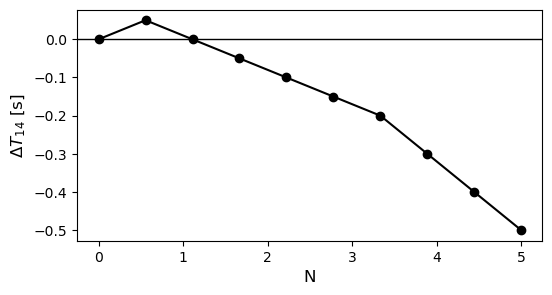

In [33]:
fig, ax = plt.subplots(figsize=(6,3))
ax.axhline(0., c='black', lw=1)
ax.plot(Nvals, (T14vals_asym - T14vals_unif)*24.*60.*60., marker='o', ms=6, c='black')
ax.set_xlabel('N', fontsize=12)
ax.set_ylabel(r'$\Delta T_{14}$ [s]', fontsize=12)
plt.show()

In [16]:
(T14vals_asym - T14vals_unif)*24.*60.*60.

array([ 0. ,  0. ,  0. , -0.1, -0.1, -0.2, -0.2, -0.4, -0.4, -0.5])